In [1]:
import ABC
import numpy as np
from Models import LinearModel
from scipy import stats

# Summary Statistics and ABC

A summary statistic $s(\cdot)$ is a projection of high-dimensional data to a lower dimension space.
$$ s:\mathbb{R}^m\to\mathbb{R}^p\text{ with }m>p $$
Sets of summary statistics $S=\{s_1,\dots,s_K\}$ are often applied to a data set, with each one capturing a different piece of information.
$$ S:\mathbb{R}^m\to\mathbb{R}^{\sum p_i}\text{ where }s_i:\mathbb{R}^m\to\mathbb{R}^{p_i}\text{ with }m>\sum p_i $$
It is common for datasets to be better represented by a matrix $\mathbb{R}^{n\times m}$ as they involve many observations, and each observation is multi-dimensional. In this case we want our summary statistics to map to dimensions $\{p_1,\dots,p_K\}$ st $n\times m\ll \sum p_i$.

Ideally, summary statistics are able to compress a dataset $D$ without compromising the information held within the dataset.

**Table of Contents**
 * [Motivation](#Motivation)
   * [Motivating Example](#motivating_example)
 * [Summary Statistics and ABC](#Summary-Statistics-in-ABC)
 * [Common Summary Statistics](#Common-Summary-Statistics)
 * [Properties of Summary Statistics](#Properties-of-Summary-Statistics)
   * [Sufficiency](#Sufficiency)
   * [Approximation Sufficiency](#Approximate-Sufficiency)
       * [Demonstration](#joyce_marjoram_demonstation)
 * [Non-Linear Projections](#Non-Linear-Projections)
 * [Summary Statistic Selection](#Summary-Statistic-Selection)
 * [(Semi-) Automatic ABC](#(Semi-)-Automatic-ABC)

## Motivation
In recent years there has been an explosion in the amount of data available. This is due to reduction in costs of computational power and storage, commercial interests, changes in societal opinion towards data collection and many other factors.

Larger datasets mean more computational power is required to run algorithms on them. Thus, being able to reduce the size of a dataset whilst still retaining most (if not all) of the meaningful information means the same analysis can be performed but require less resources.

Approximate Bayesian Computation (ABC) methods are a class of algorithms for inferring model parameters given some observed data. ABC methods are computationally inefficient as they rely on simulations, thus they often require the use of summary statistics to be computationally tractable.

<a id="motivating_example"></a>
**Motivating Example**

Suppose you are given a dataset for the results of flipping a coin $X=\{H,H,T,T,H,T,T,T,T,T\}$ and you are tasked to determine whether the coin is biased or not. You may consider using two summary statistics:
 * The proportion of times heads occurs. $s_1(X)=3/10$.
 * The proportion of times tails occurs. $s_2(X)=7/10$.

Now you analysis only involves two data points $(s_1(X),s_2(X))$ rather than $|X|=10$. This approach also has the advantage the number of data points being analysed is fixed, whereas the size of the dataset $X$ could be variable.

This is obviously a very trivial example but it is easy to see how it can be extended to larger $X$s or multiple trials.

(TODO - use how RONA data is reported to demonstrate why different summary statistics are important for different problems).

## Summary Statistics in ABC
See [ABC_Notebook](ABC_Notebook.ipynb) for details on ABC methods and its implementation.

Approximate Bayesian Computation (ABC) methods are a class of algorithms for inferring model parameters given some observed data. ABC methods are computationally inefficient as they rely on simulations, thus they often require the use of summary statistics to be computationally tractable.

ABC methods infer model parameters by generating an approximation of the posterior for each parameter, given some observed data from the true model. The better the approximation, the better the resulting model fit should be. Summary statistics influence the quality of this approximation as reducing dimensionality of data will always worsen the approximation. Our task is to choose summary statistics such that this loss of information (or at least make worthwhile improvements to the computational effiency).

ABC methods involve comparing simulated data to observed data and determining how close the two sets are to each other. When these datasets have high-dimensionality it is less likely that they coincide due to the *curse of dimensionality*. Thus transforming these datasets with summary statistics makes it easier to compare them and should reduce the number of simulations required (or improve the quality of simulations kept).

Greater reduction in dimensionality means greater reduction in computation requirements but also greater level of approximation, likely meaning the produced posterior is less representative.

In ABC there are two sources of approximation-error: only requiring simulated data to be "similar to" rather than "equal to" the observed data; and comparing summaries of the simulated $S(X)$ and observed data $S(X_{obs})$, rather than comparing the raw simulated $X$ and observed data $X_{obs}$. An effective summary statistic should balance the trade-off of these two sources of error.

## Common Summary Statistics
Most good summary statistics consider the following properties
 * Centre of the data (e.g. mean, median).
 * Spread of the data (e.g. variance).
 * Shape of the data (e.g. skew).
 * Interdependence of data-fields (e.g. correlation).
 * Quantiles of the data
The reasons for this is explained below

## Properties of Summary Statistics
(Computational efficiency)

### Sufficiency
A statistic is said to be "sufficient" for a model if no other statistic provides more information about the model's parameters. This idea can be extended to sets of statistics (i.e. summary statistics).

Formally a set of statistics $S(\cdot)=(s_1(\cdot),\dots,s_K(\cdot))$ are said to be sufficient for the data $X\sim f(\cdot;\theta)$ if

$$ \mathbb{P}(X|S(X))=\mathbb{P}(X|S(X),\theta)) $$

This demonstrates that the summary statistics $S(X)$ capture all the information the data $X$ holds about the model parameters $\theta$. The summary statistics $S(\cdot)$ are a loss-less compresion of the data. (The likelihood of data $X$ given the summary statistic values $S(X)$ is independent of the model parameters $\theta$).

It is worth noting that if a set of statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ are sufficient for $X$ then any super-set $S\supseteq S_{1:K-1}$ is also sufficient for $X$. This means that not only do we want to find a sufficient set of statistics, but also the smallest set (Minimum cardinality). Having a smaller set of statistics is desirable due to the computational efficiencies. (TODO proof)

### Approximate Sufficiency
In practice sufficient summary statistics do not always exist. Moreover, the Pitman–Koopman–Darmois Theorem states that sufficient statistics (whose dimension does not increase as sample size increase) only exist for models in the exponential family.

<!-- The concept of approximate sufficiency is a generalisation of sufficiency which can be applied to any statistical model and involves finding sets of statistics which capture a large amount of information from the sample. -->

Joyce & Marjoram introduce an approach to finding approximately sufficient statistics by building up a subset of statistics from a larger set. A statistic $S_K$ is added to the set $S_{1:K-1}=\{S_1,\dots,S_{K-1}\}$  if it is deemed to significantly increase the information extracted from the data $X$.

**Score $\delta_{K}$**

To determine the information gain from adding $S_K$ to the set $S$, first consider the following result from the product rule

$$\begin{array}{rrcl}
&\mathbb{P}(S_{1:K}(X)|\theta)&=&\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\mathbb{P}(S_{1:K-1}|\theta)\\
\implies&\ln\left\{\mathbb{P}(S_{1:K}(X)|\theta)\right\}&=&\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}+\ln\left\{\mathbb{P}(S_{1:K-1}|\theta)\right\}\\
\implies&\ln\left\{\mathbb{P}(S_{1:K}|\theta)\right\}-\ln\left\{\mathbb{P}(S_{1:K-1}|\theta)\right\}&=&\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}
\end{array}$$

This shows that $\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}$ quantifies the information gained by adding $S_K$ to $S_{1:K-1}$. Thus, we want to find statistcs $S_K$ which maximise this quantity.

Joyrce & Marjoram propose the *Score* metric $\delta_{K}$, defined as
$$ \delta_{K}:=\sup_\theta\left\{\ln\left\{\mathbb{P}(S_K|S_{1:K-1},\theta)\right\}\right\}-\inf_\theta\left\{\ln\left\{\mathbb{P}(S_K|S_{1:K-1},\theta)\right\}\right\} $$

**$\varepsilon$-Approximate Sufficiency**

A set of statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ is said to be $\varepsilon$-Sufficient relative to a statistic $S_K$ if the score of $S_K$ relative to the set $S_{1:K-1}$ is no-greater than $\varepsilon$.
$$\delta_K\leq\varepsilon$$
Note that this is equivalent to the definition of sufficiency when $S_K=X$ (identity function) and $\varepsilon=0$.

## Non-Linear Projections

## Summary Statistic Selection
The most naive way to assess summary statistics is to visually inspect the plots when they are used.

### Approximate Sufficiency
Here are details on an approach, proposed by Joyce & Majoram, to selecting summary statistics which uses the idea of approximate sufficiency.

**Algorithm**

Consider a large set of statistics $S:=\{S_1,\dots,S_N\}$ and fix some value for $\varepsilon\in\mathbb{R}^{\geq0}$. Here is the algorithm proposed by Joyce & Marjoram for finding an $\varepsilon$-sufficient subset $S^*$ of $S$, relative to the data set $X$.
<ol>
    <li>Define $S'=\emptyset$</li>
    <li>Calculate the score for statistic in $S_i\in (S\setminus S')$. See <a href="#approximating_score">below</a>.</li>
    <li>Identify the greatest score $\delta_{max}:=\max_{S_i\in S}\text{Score}(S_i,S')$.</li>
    <li>Identify a statistic which attains the greatest score $S_{max}\in\text{argmax}_{S_i\in S}\text{Score}(S_i,S')$.</li>
    <li>If $\delta_\text{max}>\varepsilon$ then add $S_{max}$ to $S'$ and return to step 2. Otherwise, stop the algorithm and return $S'$</li>
    $$S'=S'\cup S_{max}$$
    <li>When adding a new statistic, you should consider removing each summary statistic which has already been accepted so as to achieve the smallest set which is accepted.</li>
</ol>

**Variations**

This algorithm is deterministic when a deterministic method is used in step 4. However it runs in $O(N^K)$ time when $K$ summary statistics are chosen. There are variations on this algorithm which aim to improve the run-time, inc.
 * Calculate the score for each statistic in $S$ sequentially and if one below $\varepsilon$ then it is added to $S'$. (Rather than calculate score for all and chosing the maximum).
 * Remove $\varepsilon$ and instead find the best subset of size $K$.

**Implementation**
<a id="approximating_score"></a>

The main difficulty in implementing the algorithm above is in calculating the score $\delta_K$ for each statistic. Due to the nature of the problems which we are finding summary statistics for, we can only ever approximate the score $\delta_K$.

Joyce & Majoram replace the task of empirically estimating the score with the equivalent task of determining whether the odds-ratio differs from 1 more than would be expected from random noise.

Suppose you have a set of already accepted statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ and are considering adding statistic $S_K$. Suppose a large set of parameters $\Theta$ have been generated and let $\Theta_{1:K-1},\ \Theta_{1:K}$ be the set of parameters where accepted when using $S_{1:K-1}$ and $S_{1:K}$ respectively.

Define $N_{K-1}:=|\Theta_{1:K-1}|,N_K:=|\Theta_{1:K}|$

<ol>
    <li>Discretise the sets of accepted parameter $\Theta_{1:K-1},\Theta_{1:K}$ into $M$ bins. Let $C_{1:K-1},C_{1:K}$ be these two sets of counts.</li>
    <li>Calculate the expected count for each bin $E=(N_K/N_{K-1})\cdot C_{1:K-1}$. </li>
    <li>Calculate the standard-variance for each bin $$sd=\sqrt{E\cdot\frac{N_{K-1}-C_{1:K-1}}{N_{K-1}}}$$. </li>
    <li>If any values in the counts from the proposed set $C_{1:K}$ is more than four standard deviations away from the expected counts then return that the proposed distribution is significantly different from the current (ie accepted $S_k$). Otherwise, accept don't accept the change in summary stats.</li>
</ol>

A big limitation of this approach is you can only determine whether two sets of summary stats produce notable different posteriors, and not whether one posterior is better than the other. This symmetry is an issue as it means it is as likely to replace a bad choice with a good choice as it is to replace a good choice with a bad choice.

Moreover, only being able to compare and not rank sets of statistics means the algorithm above needs to be largely reworked in practice.

**Demonstration**<a id="joyce_marjoram_demonstation"></a>

I have implemented the algorithm above as `ABC.joyce_marjoram()`. Here I demonstrate its usage by applying it to choosing a set of approximately sufficient summary statistics for a linear model $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\text{Normal}(0,30)$ and the start point is known. The only parameter which needs to be learnt is the gradient of the model. The mean difference gradient between consecutive data-points is a good estimator of the gradient of the model.

I supply the algorithm with the following three summary statistics
 * $S_0$ - Mean gradient.
 * $S_1$ - $U\sim\text{Uniform}[0,6]$. This range was chosen so the variance is similar to $S_0$.
 * $S_2$ - $S_1\cdot X$ where $X\sim\text{Uniform}[0,2]$

I ran the algorithm 25 times, each time generating 10,000 samples using a uniform acceptance-kernel with bandwidth 1 and discretising the posterior into 10 bins. The results can be seen below

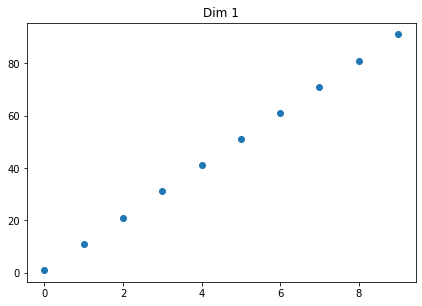

In [2]:
# define model
lm=LinearModel(  # 1+10x
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=0
    )
lm.plot_obs()

In [3]:
# define summary statistics
# Linear Model with known start point
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
rand=(lambda ys:[stats.uniform(0,6).rvs(1)[0]]) # variance set st similar number of samples accepted as mean_grad
rand_grad = (lambda ys:[mean_grad(ys)[0]*stats.uniform(0,2).rvs(1)[0]])
summary_stats=[mean_grad,rand,rand_grad]

In [4]:
%%time
# Choose summary statistics for Linear Model with known start point
param_bounds=[(1,1),(8,14)]
lm_priors_intersect_known=[stats.uniform(1,0),stats.uniform(8,6)]
returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats=ABC.joyce_marjoram(summary_stats,n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors_intersect_known,param_bounds=param_bounds,n_samples=10000,n_bins=10,printing=False)
    returned_stats.append(best_stats)

Wall time: 36min 18s, [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [0], [0], [0], [0], [0]]


In [5]:
# print results
used=[]
for x in returned_stats:
    if x not in used:
        used.append(x)
        print("([{}],{})".format(",".join([str(y) for y in x]),returned_stats.count(x)))

([0],20)
([1],5)


*Comments*

This implementation settles on the set $\{S_0\}$ in most cases, which is the best set of statistics from those provided. It is dissapoint that it picks the completely random noise $S_1$ on five occassions but this is likely due to the setup of the acceptance kernel so could be reduced with tuning (or more samples).

## (Semi-) Automatic ABC